Reference Articles:
- [Transfer learning with ResNet50](https://medium.com/@lucrece.shin/chapter-3-transfer-learning-with-resnet50-from-dataloaders-to-training-seed-of-thought-67aaf83155bc)
- [Brain Tumor Classification using ResNet50 with Intel oneAPI Toolkit](https://medium.com/@arnabroy02/brain-tumor-classification-using-resnet50-3f8648958799)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import RandomAffine, ToTensor
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

### Import Dataset

In [ ]:
# Define data transformations (resize, normalize, etc.)
resize_transform = transforms.Resize((224, 224))
validation_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define the dataset path (the directory containing "benign" and "malignant" subfolders)
dataset_path = '/content/drive/MyDrive/NUS/Y4S1/IT1244/images'

dataset = datasets.ImageFolder(root=dataset_path, transform=resize_transform)

### Visualize Feature Maps

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 49
conv_layers


Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


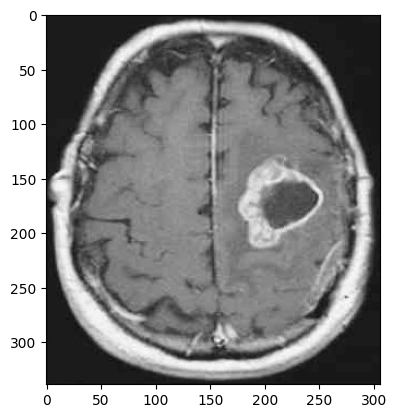

In [ ]:
# image = Image.open('/content/drive/MyDrive/IT1244/images/malignant/10.jpg')
image = Image.open('/content/drive/MyDrive/NUS/Y4S1/IT1244/images/malignant/10.jpg') # swap to this when ur running
plt.imshow(image)

image = transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print first 10 feature_maps
for feature_map in outputs[:10]:
    print(feature_map.shape)

49
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 64, 112, 112])
torch.Size([1, 256, 112, 112])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

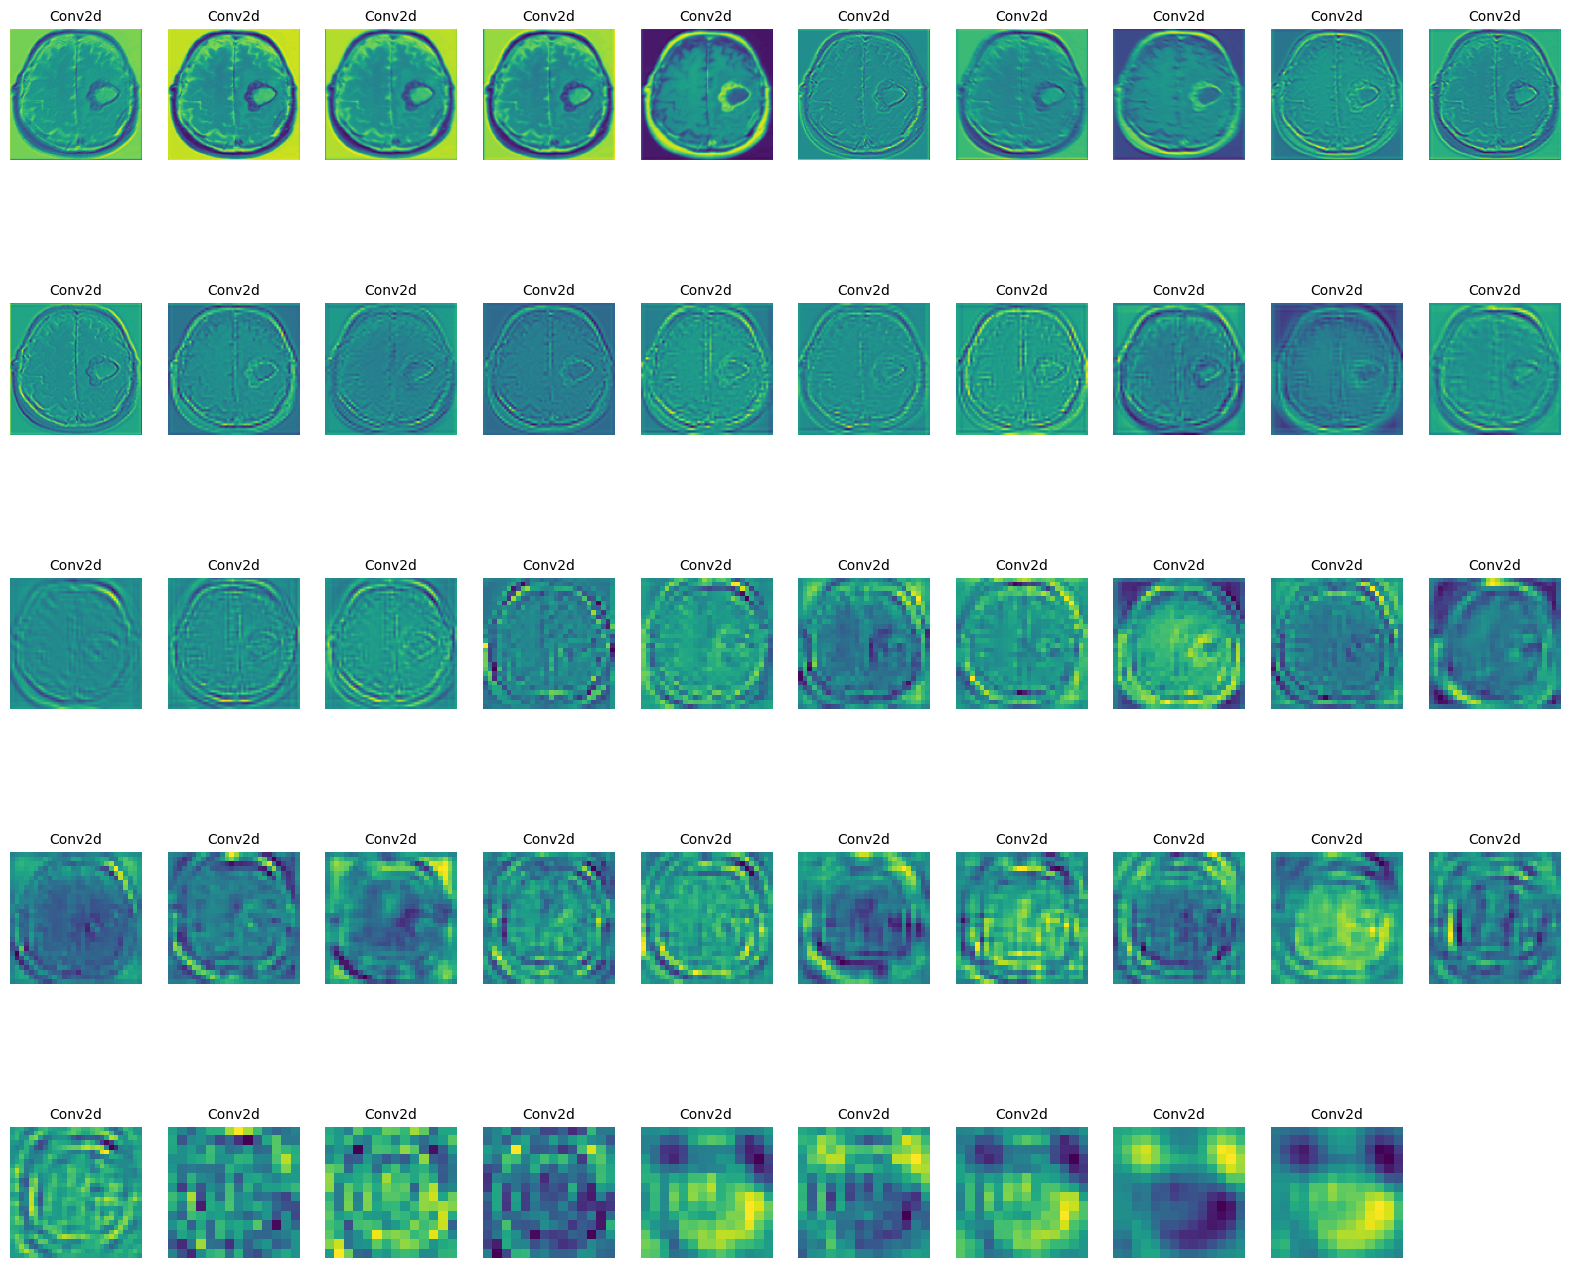

In [ ]:
fig = plt.figure(figsize=(20, 60))
for i in range(len(processed)):
    a = fig.add_subplot(17, 10, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)

### Image Augmentation

In [ ]:
class Augmentation:
  """
  Custom image augmentation class for applying multiple transformations to input images.

  Parameters:
  - num_augmentations (int): The number of augmentations to apply to each input image.
  - translation (tuple of floats): Maximum absolute fraction for horizontal and vertical translations.
  - shear (tuple of floats): Range of shearing angles (degrees).
  - rotation (tuple of floats): Range of clockwise rotation angles (degrees).

  Methods:
  - __call__(self, img_label): Apply augmentations to an input image-label pair.

  Usage:
  Instantiate the class and call it with an image-label pair to generate augmented images.

  Returns:
  - augmentations (list): A list of augmented image-label pairs. Each pair consists of an augmented image (torch.Tensor) and the original label.

  Example:
  augmentation = Augmentation()
  augmented_images = augmentation((input_image, input_label))
  """
  def __init__(self):
    self.num_augmentations = 10
    self.translation = (15 / 224, 15 / 224)
    self.shear = (-15, 15)
    self.rotation = (-25, 25)
    self.toTensor = transforms.ToTensor()
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

  def __call__(self, img_label):
    img, label = img_label
    augmentations = []
    for _ in range(self.num_augmentations):
      aug_transform = RandomAffine(degrees=self.rotation, translate=self.translation, shear=self.shear)
      new_img = aug_transform(img)
      new_img = self.toTensor(new_img)
      new_img = self.normalize(new_img)
      augmentations.append((new_img, label))

    return augmentations

### Modelling

In [ ]:
class Resnet(nn.Module):
  def __init__(self, num_classes=2):
    """
    Initialize a ResNet50 model for binary classification.

    Parameters:
    - num_classes (int): The number of output classes, typically 2 for binary classification.
    """
    super(Resnet, self).__init__()
    self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    for param in self.model.parameters(): # freeze all layers
      param.requires_grad = False
    for param in self.model.fc.parameters(): # unfreeze last fc layer
      param.requires_grad = True

    # replace last fully connected layer of resnet50
    num_in_features = self.model.fc.in_features
    self.model.fc = nn.Sequential(
        nn.Linear(in_features=num_in_features, out_features=num_classes, bias=True)
        # nn.Sigmoid() # sigmoid for binary classifcation
    )

  def forward(self, x):
    """
    Forward pass of the ResNet model.

    Parameters:
    - x (torch.Tensor): Input data (images).

    Returns:
    - torch.Tensor: Output predictions after passing through the model.
    """
    output = self.model(x)
    return output

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
  """
  Train a neural network model on a training dataset.

  Parameters:
  - model (torch.nn.Module): The neural network model to be trained.
  - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
  - criterion (torch.nn.Module): The loss function used for optimization.
  - optimizer (torch.optim.Optimizer): The optimizer for updating model weights.
  - device (torch.device): The device (CPU or GPU) on which the training will be performed.

  Returns:
  - float: The total loss over the training dataset.
  """
  model.train()
  running_loss = 0.0
  for imgs, targets in train_loader:
    imgs, targets = imgs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(imgs)
    loss = criterion(outputs, nn.functional.one_hot(targets).float())
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * imgs.size(0) # mean loss * batch size = total loss of batch

  return running_loss

In [ ]:
def validate(model, val_loader, criterion, device):
  """
  Validate a neural network model on a validation dataset.

  Parameters:
  - model (torch.nn.Module): The neural network model to be validated.
  - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
  - criterion (torch.nn.Module): The loss function used for evaluation (usually the same as used during training).
  - optimizer (torch.optim.Optimizer): The optimizer (not used during validation but required as a parameter).
  - device (torch.device): The device (CPU or GPU) on which the validation will be performed.

  Returns:
  - List: A list of predicted probablities for label 1, a list of predicted labels, list of true labels for the validation dataset.
  """
  model.eval()
  y_pred_probas = []
  y_pred = []
  y_true = []
  with torch.no_grad():
    for imgs, targets in val_loader:
      imgs, targets = imgs.to(device), targets.to(device)
      outputs = model(imgs)
      proba = F.sigmoid(outputs)[:, 1]
      _, pred = torch.max(outputs, dim=1)
      y_pred_probas.extend(proba.cpu())
      y_pred.extend(pred.cpu())
      y_true.extend(targets.cpu())
  return y_pred_probas, y_pred, y_true

In [ ]:
def calculate_evaluation_metrics(y_true, y_pred, y_pred_probas):
  """
  Calculates the evaluation metrics for validation.

  Parameters:
  - y_true (List): The true labels of the validation dataset.
  - y_pred (List): The predicted labels of the validation dataset, value can be 0 or 1.
  - y_pred_probas (List): The predicted probabilities for label 1 of the validation dataset, values are between 0 and 1.

  Returns:
  - List: A list of float values corresponding to the metrics accuracy, precision, recall, f1, specificity, roc_auc, pr_auc
  """
  roc_auc = roc_auc_score(y_true, y_pred_probas)
  precision_n, recall_n, _ = precision_recall_curve(y_true, y_pred_probas)
  pr_auc = auc(recall_n, precision_n)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  accuracy = (tn + tp) / (tn + fp + fn + tp)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  specificity = tn / (tn + fp)
  return accuracy, precision, recall, f1, specificity, roc_auc, pr_auc

### CV without Hyperparameter Tuning
- num_epochs = 10
- batch_size = 32
- learning_rate = 0.001

In [ ]:
def print_validation_performance(fold_accuracies, fold_precisions, fold_recalls, fold_specificities, fold_f1_scores, fold_roc_auc, fold_pr_auc):
  """
  Calculates and prints the validation performace.

  Parameters:
  - fold_accuracies (List): The accuracy score obtained from each fold.
  - fold_precisions (List): The precision score obtained from each fold.
  - fold_recalls (List): The recall score obtained from each fold.
  - fold_specificities (List): The specificity score obtained from each fold.
  - fold_f1_scores (List): The f1 score obtained from each fold.
  - fold_roc_auc (List): The roc_auc score obtained from each fold.
  - fold_pr_auc (List): The pr_auc score obtained from each fold.
  """
  mean_accuracy = np.mean(fold_accuracies)
  mean_precision = np.mean(fold_precisions)
  mean_recall = np.mean(fold_recalls)
  mean_specificity = np.mean(fold_specificities)
  mean_f1 = np.mean(fold_f1_scores)
  mean_roc_auc = np.mean(fold_roc_auc)
  mean_pr_auc = np.mean(fold_pr_auc)
  print(f"Mean Accuracy: {mean_accuracy:.2f}")
  print(f"Mean Precision: {mean_precision:.2f}")
  print(f"Mean Recall: {mean_recall:.2f}")
  print(f"Mean Specificity: {mean_specificity:.2f}")
  print(f"Mean F1 Score: {mean_f1:.2f}")
  print(f"Mean ROC AUC: {mean_roc_auc:.2f}")
  print(f"Mean PR AUC: {mean_pr_auc:.2f}")

In [ ]:
# set hyperparameters to be used
num_epochs = 10
batch_size = 32 # can try 16 or 64 also
learning_rate = 0.001 # lr between 0.0001 and 0.01

# Define cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # set device to cuda if using T4 GPU
print(device)

data = [item[0] for item in dataset.samples]
data_labels = [item[1] for item in dataset.samples]

augmentation = Augmentation()

# Initialize lists to store metrics for each fold
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_specificities = []
fold_f1_scores = []
fold_roc_auc = []
fold_pr_auc = []

for fold, (train_index, val_index) in enumerate(skf.split(data, data_labels)):
  print(f"Training Fold {fold + 1}/{k}")

  # Split the dataset into training and validation sets for this fold
  train_dataset = torch.utils.data.Subset(dataset, train_index)
  val_dataset = torch.utils.data.Subset(dataset, val_index)

  class_counts = dict(Counter(dataset.targets[i] for i in train_index))

  augmented_images = []
  for img_label in train_dataset:
    augmented_images.extend(augmentation(img_label))

  transformed_val_dataset = []
  for img_label in val_dataset:
    img, label = img_label
    transformed_img = validation_transform(img)
    transformed_val_dataset.append((transformed_img, label))

  # Create data loaders for training and validation
  train_loader = DataLoader(augmented_images, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size, num_workers=2)
  print(f"initial training dataset size: {len(train_dataset)}, post-transformation training dataset size: {len(augmented_images)}, validation dataset size: {len(transformed_val_dataset)}")

  # Initialize the model
  model = Resnet()
  model.to(device)

  # Define loss function and optimizer
  weight_for_0 = sum(class_counts.values()) / (class_counts[0] *  2.0) # total_samples / (num_samples_in_class_i * num_classes)
  weight_for_1 = sum(class_counts.values()) / (class_counts[1] *  2.0)
  weight = torch.tensor([weight_for_0, weight_for_1]).to(device)
  criterion = nn.BCEWithLogitsLoss(weight=weight)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Train model
  for epoch in range(num_epochs):
    running_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    avg_loss = running_loss/len(train_loader.sampler) # average loss over the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

  # Validation
  y_pred_probas, y_pred, y_true = validate(model, val_loader, criterion, device)
  accuracy, precision, recall, f1, specificity, roc_auc, pr_auc = calculate_evaluation_metrics(y_true, y_pred, y_pred_probas)

  fold_accuracies.append(accuracy)
  fold_precisions.append(precision)
  fold_recalls.append(recall)
  fold_specificities.append(specificity)
  fold_f1_scores.append(f1)
  fold_roc_auc.append(roc_auc)
  fold_pr_auc.append(pr_auc)

  print(f"Validation Accuracy (Fold {fold + 1}/{k}): {accuracy:.2f}")
  print(f"Precision (Fold {fold + 1}/{k}): {precision:.2f}")
  print(f"Recall (Fold {fold + 1}/{k}): {recall:.2f}")
  print(f"Specificity (Fold {fold + 1}/{k}): {specificity:.2f}")
  print(f"F1 Score (Fold {fold + 1}/{k}): {f1:.2f}")
  print(f"ROC AUC (Fold {fold + 1}/{k}): {roc_auc:.2f}")
  print(f"PR AUC (Fold {fold + 1}/{k}): {pr_auc:.2f}")

Training Fold 1/5
initial training dataset size: 184, post-transformation training dataset size: 1840, validation dataset size: 46


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 46.0MB/s]


Epoch 1/10, Loss: 0.6513800221940745
Epoch 2/10, Loss: 0.5186413479887921
Epoch 3/10, Loss: 0.4456368158692899
Epoch 4/10, Loss: 0.4011060585146365
Epoch 5/10, Loss: 0.3587965376999067
Epoch 6/10, Loss: 0.3406798842160598
Epoch 7/10, Loss: 0.3124654471874237
Epoch 8/10, Loss: 0.2957514405250549
Epoch 9/10, Loss: 0.2717876188133074
Epoch 10/10, Loss: 0.26274387991946674
Validation Accuracy (Fold 1/5): 0.87
Precision (Fold 1/5): 0.96
Recall (Fold 1/5): 0.83
Specificity (Fold 1/5): 0.94
F1 Score (Fold 1/5): 0.89
ROC AUC (Fold 1/5): 0.94
PR AUC (Fold 1/5): 0.96
Training Fold 2/5
initial training dataset size: 184, post-transformation training dataset size: 1840, validation dataset size: 46
Epoch 1/10, Loss: 0.6415242500927137
Epoch 2/10, Loss: 0.508710180417351
Epoch 3/10, Loss: 0.4267802958903105
Epoch 4/10, Loss: 0.3783804740594781
Epoch 5/10, Loss: 0.34330307245254515
Epoch 6/10, Loss: 0.3283637124559154
Epoch 7/10, Loss: 0.30792878192404044
Epoch 8/10, Loss: 0.27644340629162995
Epoch 9

In [ ]:
# Calculate and print the mean accuracies across folds
print_validation_performance(fold_accuracies, fold_precisions, fold_recalls, fold_specificities, fold_f1_scores, fold_roc_auc, fold_pr_auc)

Mean Accuracy: 0.82
Mean Precision: 0.89
Mean Recall: 0.83
Mean Specificity: 0.80
Mean F1 Score: 0.86
Mean ROC AUC: 0.90
Mean PR AUC: 0.93


### Hyperparameter Tuning using Manual Looping

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# to update best parameters possible for each metric
def update_best_params(metric, best_params, score, epochs, batch_size, lr):
  best_params[metric]['score'] = score
  best_params[metric]['num_epochs'] = epochs
  best_params[metric]['batch_size'] = batch_size
  best_params[metric]['learning_rate'] = lr
  return best_params

In [ ]:
def tune_hyperparameters(dataset, k, epoch_list, batch_list, lr_list, device):
  """
  Tune hyperparemeters for Resnet model.

  Parameters:
  - dataset (List): The list of tuples containing the training data, where each tuple is (PIL image, label).
  - k (int): Number of folds to be used for cross validation
  - epoch_list (List): The list of number of epochs to be explored for hyperparameter tuning.
  - batch_list (List): The list of batch sizes to be explored for hyperparameter tuning.
  - lr_list (List): The list of learning rates to be explored for hyperparameter tuning.
  - device (torch.device): The device (CPU or GPU) on which the validation will be performed.

  Returns:
  - List: A list of dictionaries, 'best_params' and 'params_result'.
    - best_params (Dict): contains the best parameters for each metric
    - params_result (Dict): contains all evaluation metrics results for all combinations of hyperparameters
  """
  params_result = {'hyperparameters': [], # (epochs, batch_size, learning_rate)
                   'accuracy': [],
                   'precision': [],
                   'recall': [],
                   'specificity': [],
                   'f1': [],
                   'roc_auc': [],
                   'pr_auc': []}

  best_params = {'accuracy': {'score': float('-inf')},
                 'precision': {'score': float('-inf')},
                 'recall': {'score': float('-inf')},
                 'specificity': {'score': float('-inf')},
                 'f1': {'score': float('-inf')},
                 'roc_auc': {'score': float('-inf')},
                 'pr_auc': {'score': float('-inf')}}

  data = [item[0] for item in dataset]
  data_labels = [item[1] for item in dataset]
  skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
  augmentation = Augmentation()

  for batch_size in batch_list:
    for num_epochs in epoch_list:
      for learning_rate in lr_list:
        print(f"Trying hyperparameters: {num_epochs} epochs, {batch_size} batch_size, {learning_rate} learning rate")

        # initialize lists to store metrics for each fold
        fold_accuracies, fold_precisions, fold_recalls, fold_specificities, fold_f1_scores = [], [], [], [], []
        fold_roc_auc, fold_pr_auc = [], []

        for fold, (train_index, val_index) in enumerate(skf.split(data, data_labels)):
          # print(f"Training Fold {fold + 1}/{k}")

          # split the dataset into training and validation sets for this fold
          train_dataset = torch.utils.data.Subset(dataset, train_index)
          val_dataset = torch.utils.data.Subset(dataset, val_index)

          class_counts = dict(Counter(dataset[i][1] for i in train_index))

          augmented_images = []
          for img_label in train_dataset:
            augmented_images.extend(augmentation(img_label))

          transformed_val_dataset = []
          for img_label in val_dataset:
              img, label = img_label
              transformed_img = validation_transform(img)
              transformed_val_dataset.append((transformed_img, label))

          # create data loaders for training and validation
          train_loader = DataLoader(augmented_images, batch_size=batch_size, shuffle=True, num_workers=2)
          val_loader = DataLoader(transformed_val_dataset, batch_size=batch_size, num_workers=2)

          # initialize the model
          model = Resnet()
          model.to(device)

          # define loss function and optimizer
          weight_for_0 = sum(class_counts.values()) / (class_counts[0] *  2.0) # total_samples / (num_samples_in_class_i * num_classes)
          weight_for_1 = sum(class_counts.values()) / (class_counts[1] *  2.0)
          weight = torch.tensor([weight_for_0, weight_for_1]).to(device)
          criterion = nn.BCEWithLogitsLoss(weight=weight)
          optimizer = optim.Adam(model.parameters(), lr=learning_rate) # can try SGD

          # train model
          for epoch in range(num_epochs):
            running_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            avg_loss = running_loss/len(train_loader.sampler) # average loss over the epoch
            # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

          # validation
          y_pred_probas, y_pred, y_true = validate(model, val_loader, criterion, device)
          accuracy, precision, recall, f1, specificity, roc_auc, pr_auc = calculate_evaluation_metrics(y_true, y_pred, y_pred_probas)

          fold_accuracies.append(accuracy)
          fold_precisions.append(precision)
          fold_recalls.append(recall)
          fold_specificities.append(specificity)
          fold_f1_scores.append(f1)
          fold_roc_auc.append(roc_auc)
          fold_pr_auc.append(pr_auc)

        # calculate and store the mean metrics for this hyperparameter combination
        mean_accuracy = np.mean(fold_accuracies)
        mean_precision = np.mean(fold_precisions)
        mean_recall = np.mean(fold_recalls)
        mean_specificity = np.mean(fold_specificities)
        mean_f1_score = np.mean(fold_f1_scores)
        mean_roc_auc = np.mean(fold_roc_auc)
        mean_pr_auc = np.mean(fold_pr_auc)

        params_result['hyperparameters'].append((num_epochs, batch_size, learning_rate))
        params_result['accuracy'].append(mean_accuracy)
        params_result['precision'].append(mean_precision)
        params_result['recall'].append(mean_recall)
        params_result['specificity'].append(mean_specificity)
        params_result['f1'].append(mean_f1_score)
        params_result['roc_auc'].append(mean_roc_auc)
        params_result['pr_auc'].append(mean_pr_auc)

        print(f"Accuracy: {mean_accuracy:.2f}")
        print(f"Precision: {mean_precision:.2f}")
        print(f"Recall: {mean_recall:.2f}")
        print(f"Specificity: {mean_specificity:.2f}")
        print(f"F1 Score: {mean_f1_score:.2f}")
        print(f"ROC-AUC: {mean_roc_auc:.2f}")
        print(f"PR-AUC: {mean_pr_auc:.2f}")
        print('----------------------------------------------------------------')

        # update best params dict
        if mean_accuracy > best_params['accuracy']['score']:
          best_params = update_best_params('accuracy', best_params, mean_accuracy, num_epochs, batch_size, learning_rate)
        if mean_precision > best_params['precision']['score']:
          best_params = update_best_params('precision', best_params, mean_precision, num_epochs, batch_size, learning_rate)
        if mean_recall > best_params['recall']['score']:
          best_params = update_best_params('recall', best_params, mean_recall, num_epochs, batch_size, learning_rate)
        if mean_specificity > best_params['specificity']['score']:
          best_params = update_best_params('specificity', best_params, mean_specificity, num_epochs, batch_size, learning_rate)
        if mean_f1_score > best_params['f1']['score']:
          best_params = update_best_params('f1', best_params, mean_f1_score, num_epochs, batch_size, learning_rate)
        if mean_roc_auc > best_params['roc_auc']['score']:
          best_params = update_best_params('roc_auc', best_params, mean_roc_auc, num_epochs, batch_size, learning_rate)
        if mean_pr_auc > best_params['pr_auc']['score']:
          best_params = update_best_params('pr_auc', best_params, mean_pr_auc, num_epochs, batch_size, learning_rate)

  print(f"Best hyperparameters: {best_params}")

  return best_params, params_result

In [ ]:
# Split dataset to 80% train, 20% test
y = [item[1] for item in dataset.samples]
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, shuffle=True, stratify=y)
print(len(train_dataset))
print(len(test_dataset))

184
46


In [ ]:
# hyperparameters for tuning
epoch_list = [10, 20, 30]
batch_list = [32, 64]
lr_list = [0.001, 0.01]
k = 5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

best_params, params_result = tune_hyperparameters(train_dataset, k, epoch_list, batch_list, lr_list, device)

cuda:0
Trying hyperparameters: 10 epochs, 32 batch_size, 0.001 learning rate
Accuracy: 0.84
Precision: 0.94
Recall: 0.82
Specificity: 0.89
F1 Score: 0.87
ROC-AUC: 0.91
PR-AUC: 0.95
----------------------------------------------------------------
Trying hyperparameters: 10 epochs, 32 batch_size, 0.01 learning rate
Accuracy: 0.82
Precision: 0.94
Recall: 0.77
Specificity: 0.90
F1 Score: 0.85
ROC-AUC: 0.93
PR-AUC: 0.96
----------------------------------------------------------------
Trying hyperparameters: 20 epochs, 32 batch_size, 0.001 learning rate
Accuracy: 0.85
Precision: 0.95
Recall: 0.81
Specificity: 0.92
F1 Score: 0.87
ROC-AUC: 0.92
PR-AUC: 0.96
----------------------------------------------------------------
Trying hyperparameters: 20 epochs, 32 batch_size, 0.01 learning rate
Accuracy: 0.80
Precision: 0.95
Recall: 0.74
Specificity: 0.92
F1 Score: 0.83
ROC-AUC: 0.92
PR-AUC: 0.95
----------------------------------------------------------------
Trying hyperparameters: 30 epochs, 32 b

Best hyperparameters:
- 'accuracy': {'score': 0.859009009009009, 'num_epochs': 10, 'batch_size': 64, 'learning_rate': 0.001},
- 'precision': {'score': 0.952196333078686, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 0.001},
- 'recall': {'score': 0.8523333333333334, 'num_epochs': 10, 'batch_size': 64, 'learning_rate': 0.001},
- 'specificity': {'score': 0.9205128205128206, 'num_epochs': 20, 'batch_size': 32, 'learning_rate': 0.01},
- 'f1': {'score': 0.8882845986704817, 'num_epochs': 10, 'batch_size': 64, 'learning_rate': 0.001},
- 'roc_auc': {'score': 0.93508547008547, 'num_epochs': 20, 'batch_size': 64, 'learning_rate': 0.01},
- 'pr_auc': {'score': 0.9655937500021687, 'num_epochs': 20, 'batch_size': 64, 'learning_rate': 0.01}}

### Training on Tuned Hyperparameters
- we picked the parameters that gave the best `pr_auc`

In [ ]:
# best hyperparameters for pr_auc
num_epochs = 20
batch_size = 64
learning_rate = 0.01

augmentation = Augmentation()

class_counts = dict(Counter(train_dataset[i][1] for i in range(len(train_dataset))))

# use train_dataset and test_dataset split during hyperparameter tuning
augmented_images = []
for img_label in train_dataset:
  augmented_images.extend(augmentation(img_label))

transformed_test_dataset = []
for img_label in test_dataset:
    img, label = img_label
    transformed_img = validation_transform(img)
    transformed_test_dataset.append((transformed_img, label))

train_loader = DataLoader(augmented_images, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(transformed_test_dataset, batch_size=batch_size, num_workers=2)

# initialize the model
model = Resnet()
model.to(device)

# define loss function and optimizer
weight_for_0 = sum(class_counts.values()) / (class_counts[0] *  2.0) # total_samples / (num_samples_in_class_i * num_classes)
weight_for_1 = sum(class_counts.values()) / (class_counts[1] *  2.0)
weight = torch.tensor([weight_for_0, weight_for_1]).to(device)
criterion = nn.BCEWithLogitsLoss(weight=weight)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # can try SGD

# train model
for epoch in range(num_epochs):
  running_loss = train_epoch(model, train_loader, criterion, optimizer, device)
  avg_loss = running_loss/len(train_loader.sampler) # average loss over the epoch
  print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

# test
y_pred_probas, y_pred, y_true = validate(model, test_loader, criterion, device)
accuracy, precision, recall, f1, specificity, roc_auc, pr_auc = calculate_evaluation_metrics(y_true, y_pred, y_pred_probas)
print('----------------------------------------------------------------')
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Precision: {precision:.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test Specificity: {specificity:.2f}")
print(f"Test F1 Score: {f1:.2f}")
print(f"Test ROC-AUC: {roc_auc:.2f}")
print(f"Test PR-AUC: {pr_auc:.2f}")

Epoch 1/20, Loss: 0.5537971807562787
Epoch 2/20, Loss: 0.31785644966623056
Epoch 3/20, Loss: 0.2295192980247995
Epoch 4/20, Loss: 0.1946897645359454
Epoch 5/20, Loss: 0.16935201468675032
Epoch 6/20, Loss: 0.13142850560986477
Epoch 7/20, Loss: 0.126022669672966
Epoch 8/20, Loss: 0.11090890104356019
Epoch 9/20, Loss: 0.09729150229174158
Epoch 10/20, Loss: 0.08736214307339295
Epoch 11/20, Loss: 0.07933871616487918
Epoch 12/20, Loss: 0.07979698660581008
Epoch 13/20, Loss: 0.06963493111340896
Epoch 14/20, Loss: 0.07082951243804848
Epoch 15/20, Loss: 0.06528848791899888
Epoch 16/20, Loss: 0.06439911800882091
Epoch 17/20, Loss: 0.052046648769275
Epoch 18/20, Loss: 0.048415131283843
Epoch 19/20, Loss: 0.048692710373712624
Epoch 20/20, Loss: 0.049235289803017744
Test Accuracy: 0.80
Test Precision: 1.00
Test Recall: 0.71
Test Specificity: 1.00
Test F1 Score: 0.83
Test ROC-AUC: 0.92
Test PR-AUC: 0.97


- Test Accuracy: 0.80
- Test Precision: 1.00
- Test Recall: 0.71
- Test Specificity: 1.00
- Test F1 Score: 0.83
- Test ROC-AUC: 0.92
- Test PR-AUC: 0.97